## Gravitation Example

In [ ]:
import numpy as np
import os
import tensorflow as tf
import torch
import maxent
from sbi_gravitation import GravitySimulator, sim_wrapper, get_observation_points
from torch.distributions.multivariate_normal import MultivariateNormal
from sbi.inference import infer
import scipy

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from functools import partialmethod
from tqdm import tqdm
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

np.random.seed(12656)
sns.set_context('paper')
sns.set_style('white',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

In [3]:
# set up true parameters
m1 = 100. # solar masses
m2 = 50. # solar masses
m3 = 75 # solar masses
G = 1.90809e5 # solar radius / solar mass * (km/s)^2
v0 = np.array([15.,-40.]) # km/s

true_params = [m1, m2, m3, v0[0], v0[1]]

# set prior means
prior_means = [85., 40., 70., 12., -30.]
prior_cov = np.eye(5) * 50

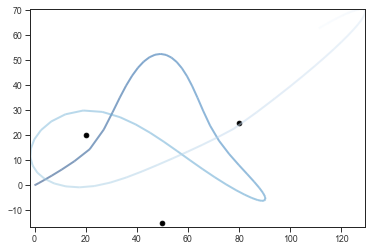

In [4]:
# generate true trajectory and apply some noise to it
if os.path.exists('true_trajectory.txt'):
    true_traj = np.genfromtxt('true_trajectory.txt')
else:
    sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=False)
    true_traj = sim.run()
    np.savetxt('true_trajectory.txt', true_traj)

if os.path.exists('noisy_trajectory.txt'):
    noisy_traj=np.genfromtxt('noisy_trajectory.txt')
else:
    sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=True)
    noisy_traj = sim.run()
    np.savetxt('noisy_trajectory.txt', noisy_traj)

observed_points = get_observation_points(noisy_traj)
observation_summary_stats = observed_points.flatten()
sim = GravitySimulator(m1, m2, m3, v0, G, random_noise=False)
sim.run()
sim.plot_traj()

In [5]:
# perform SNL inference
prior = MultivariateNormal(loc=torch.as_tensor(prior_means),
                            covariance_matrix=torch.as_tensor(torch.eye(5)*50))

posterior = infer(sim_wrapper, prior, method='SNLE', num_simulations=2048, num_workers=16)


Neural network successfully converged after 79 epochs.


In [6]:
# sample from SNL posterior
samples = posterior.sample((2000,), x=observation_summary_stats)
snl_data = np.array(samples)
np.savetxt('wide_prior_samples.txt', snl_data)

Generating samples: 100%|██████████████████████████████████████████████████████████| 2000/2000 [16:53<00:00,  1.97it/s]


In [7]:
# set up restraints for maxent
# restraint structure: [value, uncertainty, indices... ]
restraints = []
for i, point in enumerate(observed_points):
    value1 = point[0]
    value2 = point[1]
    uncertainty = 25
    index = 20 * i + 19 # based on how we slice in get_observation_points()
    restraints.append([value1, uncertainty, index, 0])
    restraints.append([value2, uncertainty, index, 1])

In [8]:
# set up maxent restraints
maxent_restraints = []

for i in range(len(restraints)):
    traj_index = tuple(restraints[i][2:])
    value = restraints[i][0]
    uncertainty = restraints[i][1]
    p = maxent.EmptyPrior()
    r = maxent.Restraint(lambda traj, i=traj_index: traj[i], value, p)
    maxent_restraints.append(r)

In [9]:
# sample from prior for maxent
if os.path.exists('maxent_prior_samples.npy'):
    prior_dist = np.load('maxent_prior_samples.npy')
else:
    prior_dist = np.random.multivariate_normal(prior_means, prior_cov, size=2048)
    np.save('maxent_prior_samples.npy', prior_dist)

In [10]:
# generate trajectories for maxent from prior samples
trajs = np.zeros([prior_dist.shape[0], 100, 2])

for i, sample in enumerate(prior_dist):
    m1, m2, m3, v0 = sample[0], sample[1], sample[2], sample[3:]
    sim = GravitySimulator(m1, m2, m3, v0, random_noise=False)
    traj = sim.run()
    trajs[i] = traj
    
maxent_trajs = trajs
np.save('maxent_raw_trajectories.npy', trajs)

In [11]:
# run maxent on trajectories
batch_size = prior_dist.shape[0]

model = maxent.MaxentModel(maxent_restraints)
model.compile(tf.keras.optimizers.Adam(1e-4), 'mean_squared_error')
# short burn-in
h = model.fit(trajs, batch_size=batch_size, epochs=5000, verbose=0)
# restart to reset learning rate
h = model.fit(trajs, batch_size=batch_size, epochs=25000, verbose=0)

np.savetxt('maxent_loss.txt', h.history['loss'])

maxent_weights = model.traj_weights
np.savetxt('maxent_traj_weights.txt', maxent_weights)

maxent_avg_traj = np.sum(trajs * maxent_weights[:, np.newaxis, np.newaxis], axis=0)
np.savetxt('maxent_avg_traj.txt', maxent_avg_traj)

### Plotting Results

In [12]:
# simulate traj generated by prior means
sim = GravitySimulator(prior_means[0], prior_means[1], prior_means[2], prior_means[3:])
prior_means_traj = sim.run()

In [13]:
# simulate trajectories from SNL samples
snl_trajs = np.zeros([snl_data.shape[0], noisy_traj.shape[0], noisy_traj.shape[1]])
for i, sample in enumerate(snl_data):
    m1, m2, m3, v0 = sample[0], sample[1], sample[2], [sample[3], sample[4]]
    sim = GravitySimulator(m1, m2, m3, v0)
    traj = sim.run()
    snl_trajs[i] = traj
    
mean_snl_traj = np.mean(snl_trajs, axis=0)
np.savetxt('mean_snl_traj.txt', mean_snl_traj)

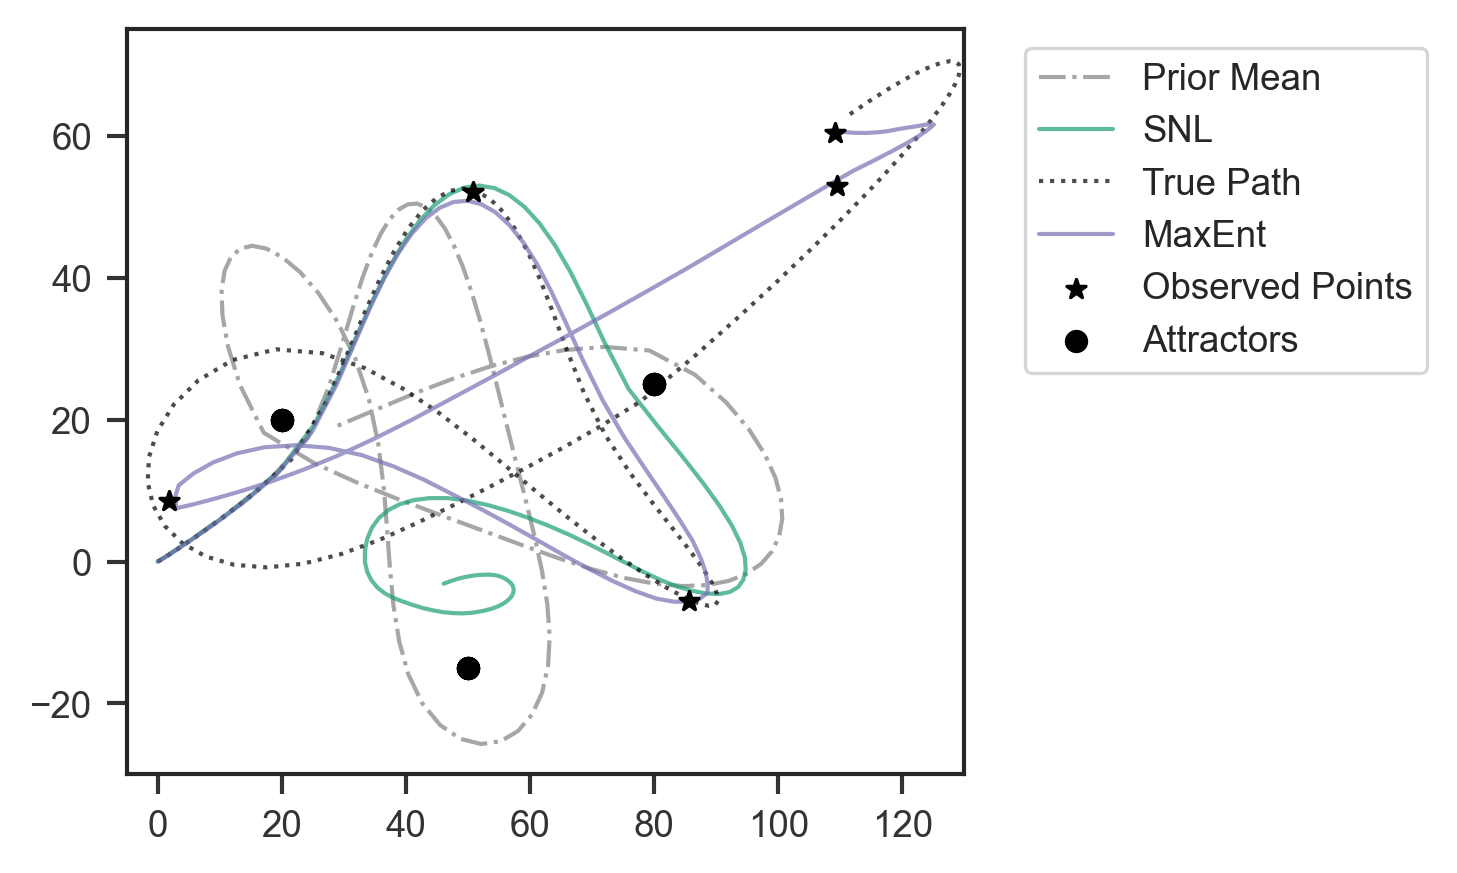

In [14]:
alpha_val = 0.7
fig, axes = plt.subplots(figsize=(5,3), dpi=300)

# plot the observation points
axes.scatter(observed_points[:,0], observed_points[:,1],
             color='black', zorder=10, marker='*', label='Observed Points')

# plot the trajectory generated by prior means
sim.set_traj(prior_means_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greys').reversed(),
              color='grey',
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-.',
              linewidth=1,
              label='Prior Mean')

# plot the SNL mean trajectory
sim.set_traj(mean_snl_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greens').reversed(),
              color=colors[0],
              fade_lines=False,
              linewidth=1,
              alpha=alpha_val,
              label='SNL')

# plot the true trajectory
sim.set_traj(true_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Reds').reversed(),
              color='black',
              fade_lines=False,
              alpha=alpha_val,
              linestyle=':',
              linewidth=1,
              label='True Path',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[2],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='MaxEnt',
              label_attractors=True)

# set limits manually
axes.set_xlim(-5, 130)
axes.set_ylim(-30, 75)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

#plt.savefig('paths_compare.png')
#plt.savefig('paths_compare.svg')
plt.show()

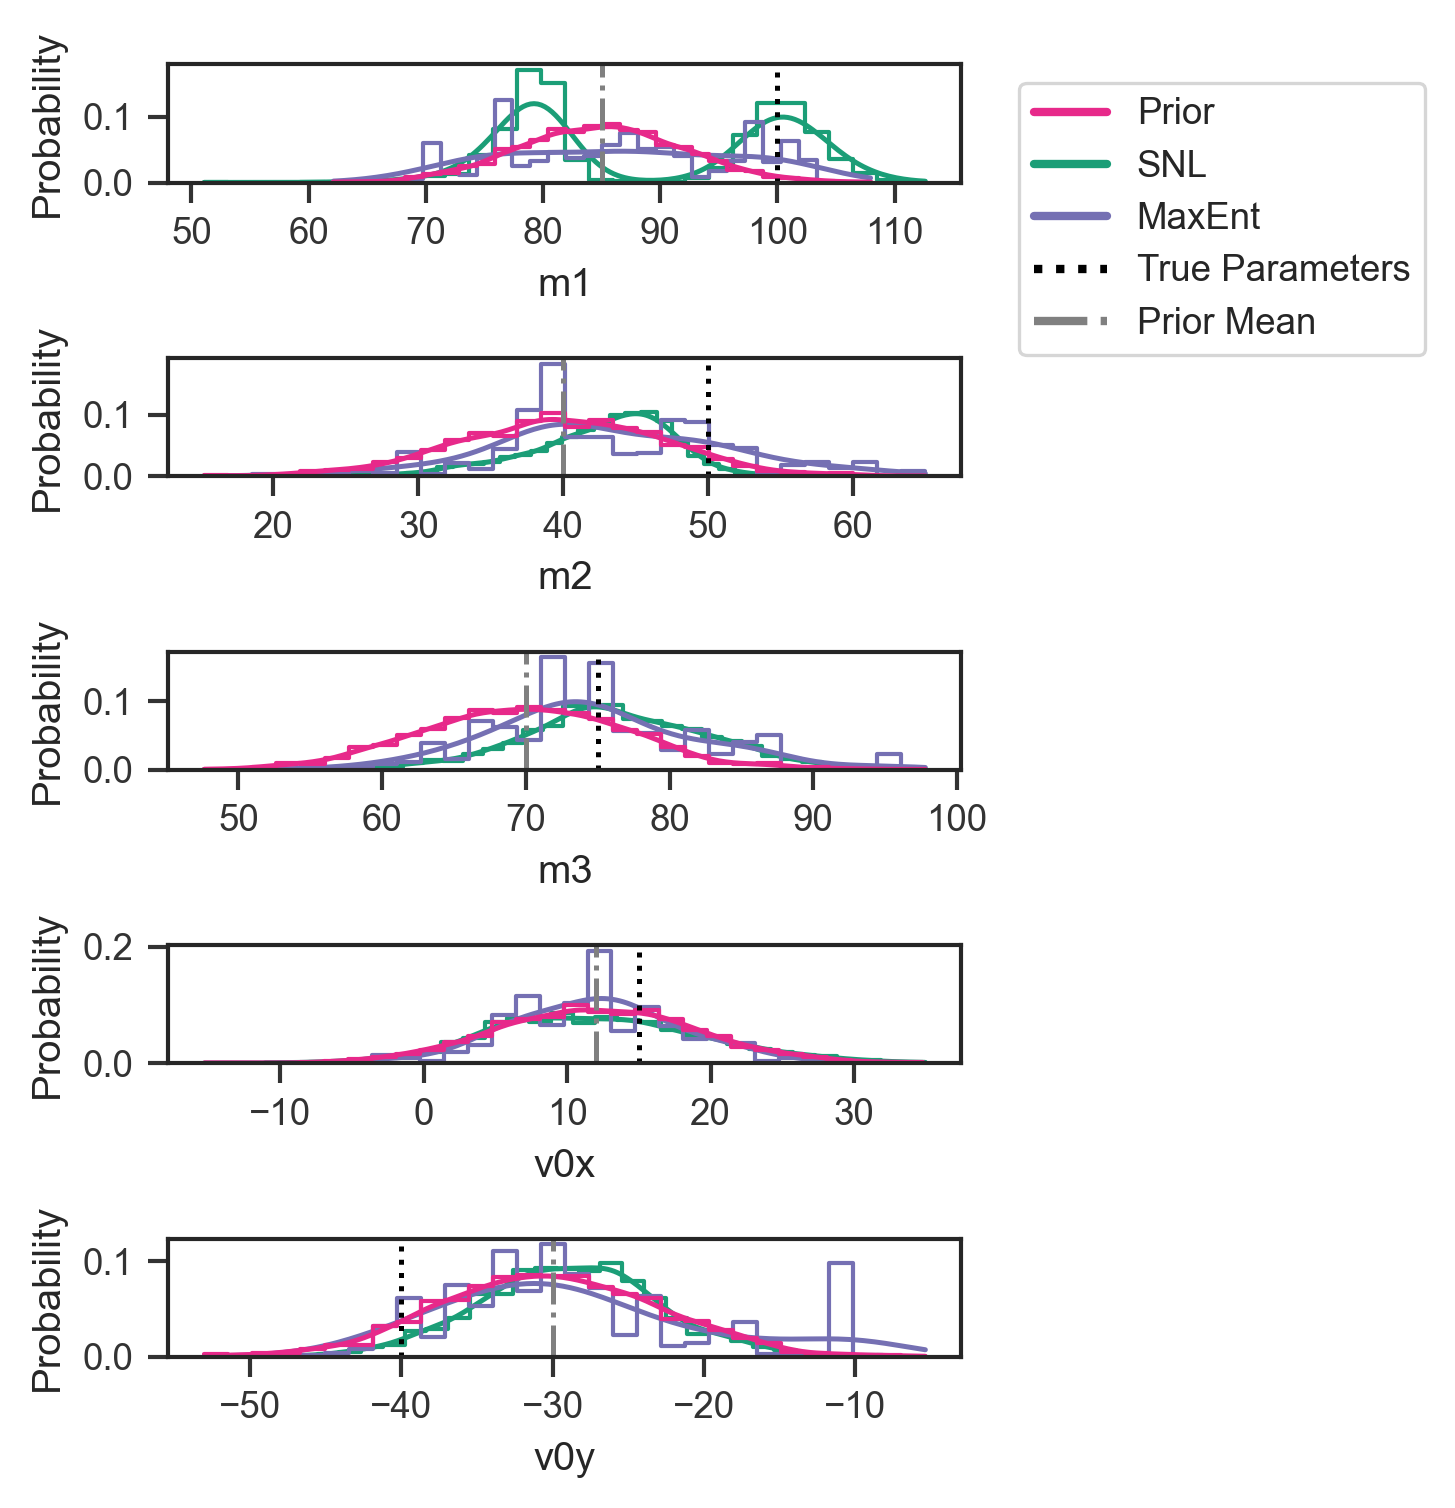

In [15]:
# set up KDE plotting of posteriors
column_names = ['m1', 'm2', 'm3', 'v0x', 'v0y']

snl_dist = np.array(snl_data)
snl_frame = pd.DataFrame(snl_dist, columns = column_names)

maxent_dist = np.load('maxent_prior_samples.npy')
maxent_frame = pd.DataFrame(maxent_dist, columns = column_names)

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5,5), dpi=300, sharex=False)

# iterate over the five parameters
n_bins = 30
for i, key in enumerate(column_names):
    sns.histplot(data=snl_frame, x=key, ax=axes[i], color=colors[0],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, lw=1.0)
    sns.histplot(data=maxent_frame, x=key, ax=axes[i], color=colors[2],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, weights=maxent_weights, lw=1.0)
    sns.histplot(data=maxent_frame, x=key, ax=axes[i], color=colors[3],
                 stat='probability', element='step', kde=True, fill=False,
                 bins=n_bins, lw=1.0)
    axes[i].axvline(prior_means[i], ls='-.', color='grey', lw=1.2)
    axes[i].axvline(true_params[i], ls=':', color='black', lw=1.2)
    axes[i].set_xlabel(key)
    
# custom lines object for making legend
custom_lines = [Line2D([0], [0], color=colors[3], lw=2),
                Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color='black', ls=':', lw=2),
                Line2D([0], [0], color='grey', ls='-.', lw=2)]
axes[0].legend(custom_lines, ['Prior', 'SNL',  'MaxEnt', 'True Parameters', 'Prior Mean'],
               loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

#plt.savefig('posterior_compare.png')
#plt.savefig('posterior_compare.svg')
plt.show()

In [16]:
# calculating cross-entropy values
def get_crossent(prior_samples, posterior_samples, epsilon = 1e-7, x_range=[-100, 100], nbins=40, post_weights=None):
    prior_dists = []
    posterior_dists = []
    crossents = []
    for i in range(5):
        prior_dist, _ = np.histogram(prior_samples[:,i], bins=nbins, range=x_range, density=True)
        prior_dists.append(prior_dist)
        posterior_dist, _ = np.histogram(posterior_samples[:,i], bins=nbins, range=x_range, density=True, weights=post_weights)
        posterior_dists.append(posterior_dist)
        crossents.append( np.log(posterior_dist+epsilon) * (prior_dist + epsilon) )
    return -np.sum(crossents)

snl_prior = np.random.multivariate_normal(mean=prior_means, cov=np.eye(5)*50, size=snl_dist.shape[0])
snl_crossent = get_crossent(snl_prior, snl_dist)

maxent_prior = np.random.multivariate_normal(prior_means, np.eye(5)*50, size=2048)
maxent_crossent = get_crossent(maxent_prior, maxent_prior, post_weights=maxent_weights)

print(f'CROSS-ENTROPY:\nSNL: {snl_crossent}\nMaxEnt: {maxent_crossent}')

crossent_values = [snl_crossent, maxent_crossent]
np.savetxt('crossent_values.txt', np.array(crossent_values), header='SNL, MaxEnt')

CROSS-ENTROPY:
SNL: 3.7691315191629897
MaxEnt: 3.436334810094098


### MaxEnt With Variational

In [17]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [18]:
x = np.array(prior_means, dtype=np.float32)
y = np.array(prior_cov, dtype=np.float32)
i = tf.keras.Input((100,2))
l = maxent.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.MultivariateNormalFullCovariance(
    loc=x, covariance_matrix=y))(l)
model = maxent.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.SGD(1e-3))
model.summary()
model(tf.constant([1., 2., 3., 4., 5.]))

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Model: "parameter_joint"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
trainable_input_layer (Train (None, 5)                 5         
_________________________________________________________________
distribution_lambda (Distrib ((None, 5), (None, 5))    0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


<tfp.distributions.MultivariateNormalFullCovariance 'parameter_joint_distribution_lambda_MultivariateNormalFullCovariance' batch_shape=[5] event_shape=[5] dtype=float32>

In [19]:
def simulate(x, nsteps=100):
        '''params_list should be: m1, m2, m3, v0[0], v0[1] in that order'''
        # double nsteps b/c we flatten the (x,y) coordinates
        output = np.zeros((x.shape[0], nsteps, 2))
        for i in range(x.shape[0]):
            params_list = x[i,0,:]
            m1, m2, m3 = float(params_list[0]), float(params_list[1]), float(params_list[2])
            v0 = np.array([params_list[3], params_list[4]], dtype=np.float64)
            this_sim = GravitySimulator(m1, m2, m3, v0, random_noise=False, nsteps=nsteps)
            # set to 1D to make hypermaxent setup easier
            this_traj = this_sim.run()#.flatten()
            output[i] = this_traj
        return(output)


In [20]:
def get_observation_points_from_flat(flat_traj):
    recovered_traj = flat_traj.reshape([-1,2])
    return get_observation_points(recovered_traj)#.flatten()

In [21]:
r = []
true_points = get_observation_points(noisy_traj)
true_points_flat = true_points.flatten()
for i, point in enumerate(true_points_flat):
    r.append(maxent.Restraint(lambda x: get_observation_points_from_flat(x)[i],
                              point,
                              maxent.EmptyPrior()))
hme_model = maxent.HyperMaxentModel(maxent_restraints, model, simulate)
hme_model.compile(tf.keras.optimizers.Adam(1e-4), 'mean_squared_error')

In [22]:
hme_results = hme_model.fit(epochs=30000, sample_batch_size=2048//4, outter_epochs=4, verbose=0) # one-quarter of plain maxent batch size

In [23]:
hme_predicted_params = hme_model.weights[1]
hme_trajectory_weights= hme_model.traj_weights
variational_trajs = hme_model.trajs.reshape([hme_model.trajs.shape[0], -1, 2])
maxent_variational_avg_traj = np.sum(variational_trajs * hme_trajectory_weights[:, np.newaxis, np.newaxis], axis=0)
np.savetxt('maxent_variational_avg_traj.txt', maxent_variational_avg_traj)

In [24]:
# simulate traj generated by prior means
sim = GravitySimulator(prior_means[0], prior_means[1], prior_means[2], prior_means[3:])
prior_means_traj = sim.run()

In [25]:
mean_snl_traj = np.genfromtxt('mean_snl_traj.txt')
maxent_avg_traj = np.genfromtxt('maxent_avg_traj.txt')
maxent_variational_avg_traj = np.genfromtxt('maxent_variational_avg_traj.txt')

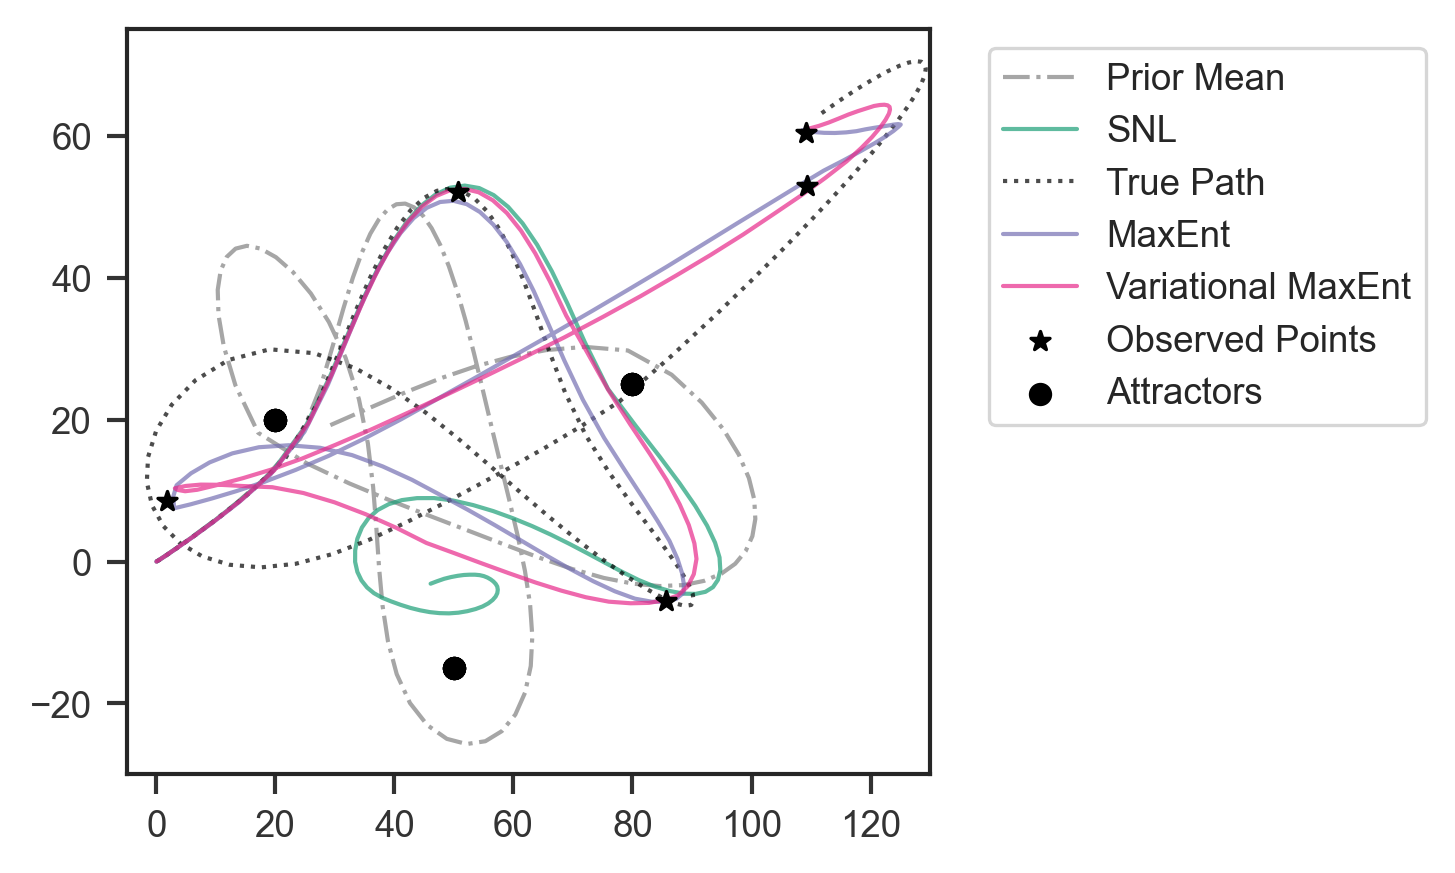

In [26]:
alpha_val = 0.7
fig, axes = plt.subplots(figsize=(5,3), dpi=300)

# plot the observation points
axes.scatter(observed_points[:,0], observed_points[:,1],
             color='black', zorder=10, marker='*', label='Observed Points')

# plot the trajectory generated by prior means
sim.set_traj(prior_means_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greys').reversed(),
              color='grey',
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-.',
              linewidth=1,
              label='Prior Mean')

# plot the SNL mean trajectory
sim.set_traj(mean_snl_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Greens').reversed(),
              color=colors[0],
              fade_lines=False,
              linewidth=1,
              alpha=alpha_val,
              label='SNL')

# plot the true trajectory
sim.set_traj(true_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Reds').reversed(),
              color='black',
              fade_lines=False,
              alpha=alpha_val,
              linestyle=':',
              linewidth=1,
              label='True Path',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[2],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='MaxEnt',
              label_attractors=False)

# plot the maxent average trajectory
sim.set_traj(maxent_variational_avg_traj)
sim.plot_traj(fig=fig,
              axes=axes,
              make_colorbar=False,
              save=False,
              cmap=plt.get_cmap('Oranges').reversed(),
              color=colors[3],
              fade_lines=False,
              alpha=alpha_val,
              linestyle='-',
              linewidth=1,
              label='Variational MaxEnt',
              label_attractors=True)

# set limits manually
axes.set_xlim(-5, 130)
axes.set_ylim(-30, 75)

plt.legend(loc='upper left', bbox_to_anchor=(1.05,1.))
plt.tight_layout()

plt.savefig('paths_compare.png')
plt.savefig('paths_compare.svg')
plt.show()